> ### EEE4423: Signal Processing Lab

# LAB \#6: Semantic Segmentation

<div style="text-align: right"> Please upload your file @ yscec in the form of [ID_Name_Lab6.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).


<h2><span style="color:blue">2014142243 차현수</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-04-13 20:43:51.771598


In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models




## Introduction


### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1aR-RSJCsSEROjmQych61RbIhBul9cqA1" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates. 


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1l2-Degy7LpK20NbooHosRV8NzeRvNdPd" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

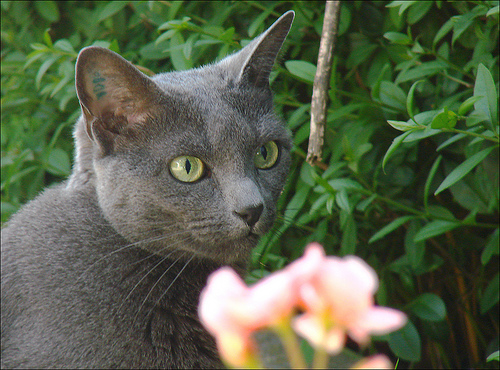

In [3]:
from PIL import Image
test_img_path = 'dataset/lab7/img/2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [4]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [5]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [7]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
res = torch.zeros((224,224)).cuda()

In [8]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [9]:
print(res)

tensor([[285., 285., 285.,  ...,  24., 285., 281.],
        [285., 285., 285.,  ...,  24.,  24., 282.],
        [285., 285., 285.,  ..., 285.,  24.,  24.],
        ...,
        [150., 360., 360.,  ..., 254., 254., 382.],
        [285., 285., 287.,  ..., 174., 254.,  87.],
        [285., 285., 285.,  ..., 254., 254., 644.]], device='cuda:0')


**Visualize the output, classified as 'egyptian cat' (285)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


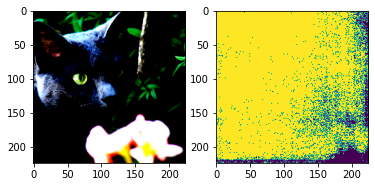

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1sWibO6xfau_kfWt-2T_rh_ARrzsR4PRV" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [11]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)
        
        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)
        
        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [12]:
conv_vgg = ConvolutionalVGG().cuda()
conv_vgg

ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [13]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [14]:
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [15]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[285, 285, 285, 285, 285, 285, 285, 285, 285],
         [285, 285, 245, 285, 285, 285, 285, 285, 285],
         [285, 285, 245, 245, 245, 281, 245, 287, 282],
         [285, 285, 285, 285, 285, 281, 285, 285, 285],
         [285, 285, 285, 285, 285, 281, 281, 281, 285]]], device='cuda:0')

Well...

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012  [1 point]
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [16]:
import torchvision.models as models

class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)
        
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        # fc8
        #############
        # CODE HERE # PASCAL 20 object, 1 background class
        self.fc8 = nn.Conv2d(4096, 21, 1)
        self.up = nn.Upsample(size=512, mode='bilinear')
        
        #############
        
        self.copy_params_from_vgg16()
        

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)
        
        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)
        
        score = self.fc8(fc8)
        
        #############
        # CODE HERE #
        score = self.up(score)
        #############
        # Upsample to original resolution

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [17]:
conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()

In [18]:
def decode_labels(mask, num_classes=21):
    from PIL import Image         
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
        
    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [19]:
model_data = torch.load('pretrain/lab7/vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)

<All keys matched successfully>

In [20]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

/home/stephencha/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


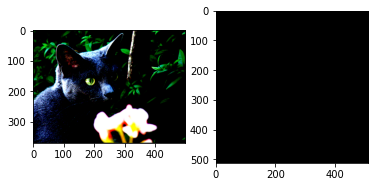

In [21]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### 1.3.1 Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1IfoOAei35ydfeWu5qlXhZwNnW8cy_tJn"  onerror="this.style.display='none'" /><br><br>


- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

#### 1.3.2 Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1DCDuj_6IhA8HdZzE8OZkrYIuDeevtjKV"  onerror="this.style.display='none'" /><br><br>

- The dilated convolution introduces 'a dilation rate' to the standard convolution.

- The dilation rate means a spacing value between elements of a kernel, which enlarges the receptive field without introducing additional parameters.

- For example, a $3\times3$ kernel with a dilation rate of 2 has the same receptive field as a $5\times5$ kernel while it still use 9 parameters only, compared to the $5\times5$ the uses 25 parameters. 

## 2. [Lab] Semantic segmentation 

### 2.1 Write a FCN8s model  [4 points]

<img src="https://drive.google.com/uc?export=view&id=1icsmWH1-N_g90VJOg7zyIFVec-TmPscA"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [22]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size()) #160
    print(b.size()) #120
    
print(a.size()[3])
# crop boundary 
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]
b_temp = b[:, :, 5: 5+a.size(2), 5:5+a.size(3)]

print('After crop a size: ', a.size())
print(b_temp.size())

# add connection with weight
c = 0.01*a + b 

print(c.size()) #120

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])
140
After crop a size:  torch.Size([1, 1, 120, 120])
torch.Size([1, 1, 115, 115])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [23]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features
        
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        #############
        # CODE HERE #
        self.pool4 = self.features[:24]
        self.pool3 = self.features[:17]
        
        self.predict1 = nn.Conv2d(4096, n_class, 1)
        self.predict2 = nn.Conv2d(512, n_class, 1)
        self.predict3 = nn.Conv2d(256, n_class, 1)

        self.deconv1 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)
        ############# 

        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)
        
        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode=True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        #############
        # CODE HERE #
        pool4 = self.pool4(x)
        pool3 = self.pool3(x)
        
        ##FC Layers##
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        x_fc = self.drop7(fc7)
        ##END##
        
        ##1##
        x1 = self.predict1(x_fc)
        x1 = self.deconv1(x1)
        deconv1_r = x1

        ##2##
        x2 = self.predict2(pool4*0.01)

        # Crop Boundary 5
        x2 = x2[:, :, 5:5 + deconv1_r.size()[2], 5:5 + deconv1_r.size()[3]] #size()[2], size()[3]
        predict2_r = x2
        
        x_temp = deconv1_r + predict2_r
        x_temp = self.deconv2(x_temp)
        deconv2_r = x_temp

        x3 = self.predict3(pool3*0.0001)
        x3 = x3[:, :, 9:9 + deconv2_r.size()[2], 9:9 + deconv2_r.size()[3]]
        predict3_r = x3

        x4 = deconv2_r + predict3_r
        x5 = self.deconv3(x4)
        x = x5[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous() # Make same size input x and output x
        ############# 
        
        return x

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))
            
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [24]:
model = FCN8s().cuda()

**Data Loader functions**

In [25]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='dataset/lab7/gt', img_path='dataset/lab7/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)
    
    labels = gt[np.newaxis, :].copy()

    return images, labels

**Data load**

In [26]:
img_list = read_file('dataset/lab7/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

In [27]:
lr = 1e-5 # choose your lr, 6(not bad)
wd = 0.0005

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
optimizer.zero_grad()
max_iter = 100000

### 2.2 Write train code and print loss [2 points]
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [28]:
def loss_calc(out, label):
    #############
    # CODE HERE # 논문을 참고하거나 Loss functon을 pytorch.org에서 참고.
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, label)
    return loss
    ############# 

Train iteration: 100, Loss: 2.88619620770216, Elapsed Time: 0.08710932731628418 sec
Train iteration: 200, Loss: 1.6488963294774295, Elapsed Time: 0.10985636711120605 sec
Train iteration: 300, Loss: 1.403236359655857, Elapsed Time: 0.11132025718688965 sec
Train iteration: 400, Loss: 1.514166075885296, Elapsed Time: 0.0697786808013916 sec
Train iteration: 500, Loss: 1.6383875421434642, Elapsed Time: 0.08501768112182617 sec
Train iteration: 600, Loss: 1.3673583737015724, Elapsed Time: 0.12792611122131348 sec
Train iteration: 700, Loss: 1.2954612617194652, Elapsed Time: 0.10212421417236328 sec
Train iteration: 800, Loss: 1.2701332350820302, Elapsed Time: 0.10838699340820312 sec
Train iteration: 900, Loss: 1.1678849767148494, Elapsed Time: 0.06796026229858398 sec
Train iteration: 1000, Loss: 1.1906356313079596, Elapsed Time: 0.0658884048461914 sec
Train iteration: 1100, Loss: 1.2923489169962705, Elapsed Time: 0.10623526573181152 sec
Train iteration: 1200, Loss: 1.3530201072990895, Elapsed T

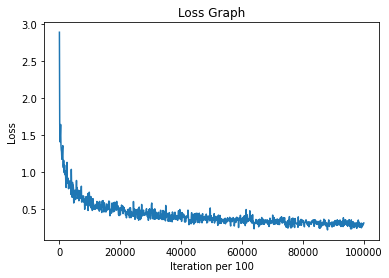

In [29]:
running_loss = 0.0

import time

xlabel = []
ylabel = []

for iter in range(max_iter + 1):
    start = time.time()
    inputs, label = get_data(next(data_gen))
    #############
    # CODE HERE # 앞서 구현한 실험과 유사하게 하면 된다.
    
    inputs = inputs.cuda()
    label = torch.LongTensor(label).cuda()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = loss_calc(outputs, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    if iter%100 == 99:
        xlabel.append(iter)
        ylabel.append(running_loss/100)
        end = time.time()
        print('Train iteration: {}, Loss: {}, Elapsed Time: {} sec'.format(iter+1, running_loss/100, end-start))
        running_loss = 0.0

print("Finish for training")
plt.title('Loss Graph')
plt.xlabel('Iteration per 100')
plt.ylabel('Loss')
plt.plot(xlabel, ylabel)
plt.show()
############# 

### 2.3 Discuss the result [3 points]
- Compare and Discuss the results. Note that it must contain the quantitative and qualitative results.
- Use the below 'validation_miou' function to evaluate your model. Your model should perform better than the example model **(0.5 mIoU)**.
- Use the above 'decode_label' function to visualize the network output.

In [30]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))
    
    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)
    
    val_list = open('dataset/lab7/list/val.txt').readlines()
    
    with torch.no_grad():
        for idx, i in enumerate(val_list):
            #print('{}/{} ...'.format(idx + 1, len(val_list)))

            img = cv2.imread(os.path.join('dataset/lab7/img', i[:-1] + '.jpg')).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('dataset/lab7/gt', i[:-1] + '.png'), 0)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))
        
    return np.sum(miou) / len(miou)

In [31]:
validation_miou(model)

Mean iou =  0.5529470114726536


0.5529470114726536

In [32]:
with torch.no_grad():
    conv_out = model(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


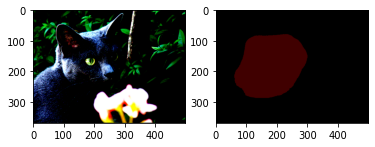

In [33]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)

Result report by written Cha, Hyunsoo
=

Analyze Algorithm
==

This experiment was conducted to implement semantic segmentation directly. Semantic segmentation is simply a technique for separating images into classes. In this experiment, images are analyzed in pixels, so it tend to be more difficult than existing models. The network that I must implement themselves is FCN8s. This neural network consists of fine-tuning some parts of the existing VGG16 network and adding new deconvolution layers and softmax layers. To be more specific, pass the feature vector through the pool3 layer of VGG16. Cut the crop boundaries so that they are 9. Continue to pass the feature vector through the predict2 layer through the pool4 layer of VGG16. The feature vector is then set to crop boundary 5 to equal the layer size of deconv1. Finally, the feature vector, which passes the fully-convolutional layer of VGG16, becomes larger in size through the deconv1 layer. The deconv1 and predict2 layers are then combined to pass through the deconv2 layer. Add the feature vector that passed through to the feature vector that passed through predict3. If this feature vector is passed by setting the deconv3 layer to crop boundary 31, the final feature vector is released. Writing a class exactly in the aforementioned order results in the desired fcn8s model. Note that when entering the feature vector in the precinct2 layer, multiply the weight of 0.01 to reduce the dependence on pool4. Similarly, pool3 is multiplied by weight by 0.0001 to pass through the precinct3 layer. It was calculated using the parameters of the VGG16 layer and upsampling weight to reflect the characteristics of the previous models.

Compare and Discuss the Results
==

>Note that it must contain the quantitative and Qualitative Results

The mIoU was calculated by varying the learning rate. When the running rate is given 1e-6, the loss falls below 1 when the period is 10,000. When the learning rate is set to 1e-7, the moment when the loss falls below 1 is about 78,000. The model follows the fixed scheduling learning rate. Simply looking at it, it can be seen that the learning rate falls properly when 1e-6 is. The total iteration is set to 100000. The reason for such a number was to obtain the highest mIoU possible. The loss function used cross-entry loss as presented in the problem, and it can be seen that the loss value decreases slowly. The final which is mean IoU results showed that 0.12 at learning rate 1e-7 and 0.459 at learning rate 1e-6. The reason why I made it a very large value was that it was set a large value through the reference in the example file. Also, given the falling aspect of loss, it was assumed that only sufficient iteration would guarantee high accuracy and that was true.
Finally, when the learning rate was set to 1e-5 and weight decy was 0.0005, the mIoU was 0.552. As a result, I was able to achieve the goal.